In [1]:
import yfinance as yf 
import duckdb
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from torch.nn import Module

torch.set_num_threads(12)
torch.set_num_interop_threads(12)
    
class StockPrediction():
    def __init__(self):
        pass

    def load_yfinance_data(self, enterprise, start_date, end_date):
        yf_df = yf.download(enterprise, start=start_date, end=end_date).reset_index()

        ds = duckdb.sql(f"""
            DROP TABLE IF EXISTS finance;
            CREATE TABLE finance AS ( 
                SELECT
                "('Date', '')" as dt_time
                ,date_trunc('day', "('Date', '')") as dt
                ,"('Adj Close', '{enterprise}')" as adj_close
                ,"('Close', '{enterprise}')" as close
                ,"('High', '{enterprise}')" as high
                ,"('Low', '{enterprise}')" as low
                ,"('Open', '{enterprise}')" as open
                ,"('Volume', '{enterprise}')" as volume

                FROM yf_df
            )
            """)
        
    def get_yfinance_dataset(self):
        finance_dataset = duckdb.sql("""
            SELECT         
                * 
            FROM finance
                """)    
        

        #finance_dataset.show()
        
        return finance_dataset.df()
    
    def get_train_n_test(self, test_size = 0.65):
        yfinance_dataset = self.get_yfinance_dataset()

        timeseries = yfinance_dataset[["adj_close"]].values.astype('float32')
        dt_time = yfinance_dataset['dt']

        train_size = int(len(timeseries) * test_size)
        test_size = len(timeseries) - train_size
        train, test = timeseries[:train_size], timeseries[train_size:]
        dt_train, dt_test = dt_time[:train_size], dt_time[train_size:]

        return dt_train, train, dt_test, test
    
    def plot_yfinance_dataset(self, plot_test=False):    
        dt_train, train, dt_test, test = self.get_train_n_test()

        
        if (plot_test):
            dt_time = dt_test
            timeseries = test
        else:
            dt_time = dt_train
            timeseries = train            


        plt.plot(dt_time, timeseries)
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

        plt.xticks(rotation=45)
        plt.show()         


    def create_torch_dataset(self, dataset, lookback):
        """Transform a time series into a prediction dataset
        
        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y = [], []
        for i in range(len(dataset)-lookback):
            feature = dataset[i:i+lookback]
            target = dataset[i+1:i+lookback+1]
            X.append(feature)
            y.append(target)
        return torch.tensor(X), torch.tensor(y)
    
    def get_torch_train_n_test(self, test_percentage = 0.65, lookback = 4):
        _x_train, _y_train, _x_test, _y_test = self.get_train_n_test(0.65)
        
        x_train, y_train = self.create_torch_dataset(_y_train, lookback=lookback)
        x_test, y_test = self.create_torch_dataset(_y_test, lookback=lookback) 

        return x_train, y_train, x_test, y_test
    
    def train_model(self, model: Module, x_train, y_train, x_test, y_test, n_epochs = 100):
        self.model = model

        optimizer = optim.Adam(self.model.parameters())
        loss_fn = nn.MSELoss()
        loader = data.DataLoader(data.TensorDataset(x_train, y_train), shuffle=True, batch_size=8)
        
        for epoch in range(n_epochs):
            self.model.train()
            for X_batch, y_batch in loader:
                y_pred = self.model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # Validation
            if epoch % 100 != 0:
                continue
            self.model.eval()
            with torch.no_grad():
                y_pred = self.model(x_train)
                train_rmse = np.sqrt(loss_fn(y_pred, y_train))
                y_pred = self.model(x_test)
                test_rmse = np.sqrt(loss_fn(y_pred, y_test))
            print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


    def test_model(self, model: Module, x_train, x_test, lookback=4):            
        yfinance_dataset = self.get_yfinance_dataset()
        test_size = 0.65

        timeseries = yfinance_dataset[["adj_close"]].values.astype('float32')
        train_size = int(len(timeseries) * test_size)

        with torch.no_grad():
            # Initialize empty arrays for train and test predictions
            train_plot = np.ones((len(timeseries), 1)) * np.nan
            test_plot = np.ones((len(timeseries), 1)) * np.nan

            # Get model predictions for train and test
            y_pred_train = model(x_train)[:, -1, :].numpy()
            y_pred_test = model(x_test)[:, -1, :].numpy()

            # Debug shapes
            print("Shape of y_pred_train:", y_pred_train.shape)
            print("Shape of train_plot slice:", train_plot[lookback:lookback + len(y_pred_train)].shape)

            # Ensure assignment matches the correct slice length
            train_plot[lookback:lookback + len(y_pred_train), 0] = y_pred_train[:, 0]
            test_plot[train_size + lookback:train_size + lookback + len(y_pred_test), 0] = y_pred_test[:, 0]

        # Plot the results
        plt.plot(timeseries, label="Actual")
        plt.plot(train_plot, c='r', label="Train Predictions")
        plt.plot(test_plot, c='g', label="Test Predictions")
        plt.legend()
        plt.show()

In [2]:
enterprise = 'GOOGL' 
start_date = '2018-01-01'  
end_date = '2024-07-20' 

stock_p  = StockPrediction()

stock_p.load_yfinance_data(enterprise, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
yfinance_dataset = stock_p.get_yfinance_dataset()

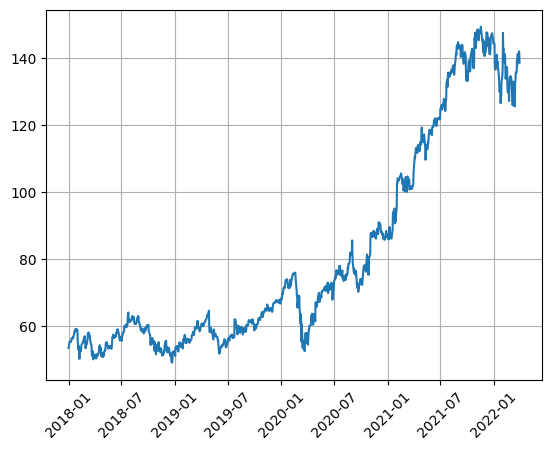

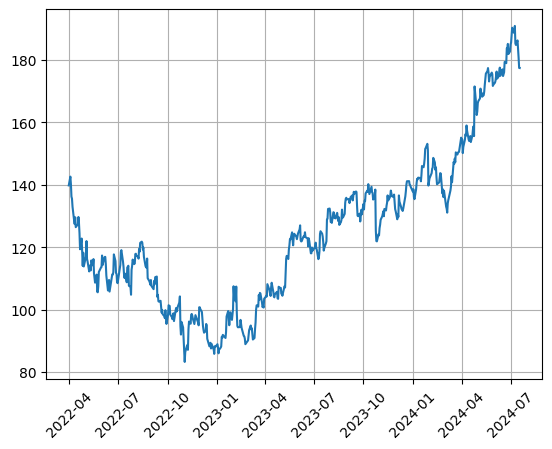

In [4]:
stock_p.plot_yfinance_dataset(False)
stock_p.plot_yfinance_dataset(True)

In [5]:
class StockModel(Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    
model = StockModel()

x_train, y_train, x_test, y_test = stock_p.get_torch_train_n_test()

stock_p.train_model(model, x_train, y_train, x_test, y_test, n_epochs = 100)

/tmp/ipykernel_10227/4191162290.py:99: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)
/tmp/ipykernel_10227/4191162290.py:130: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
/tmp/ipykernel_10227/4191162290.py:132: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 80.1680, test RMSE 119.1818


Shape of y_pred_train: (1066, 1)
Shape of train_plot slice: (1066, 1)


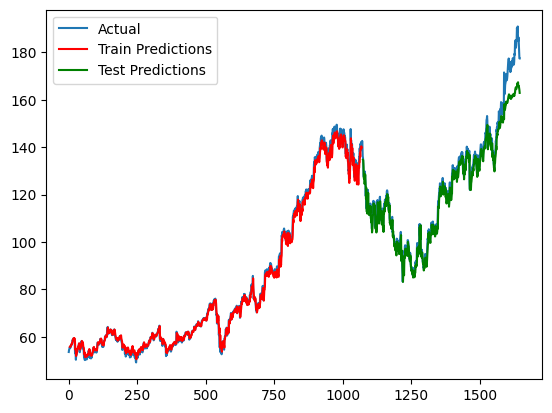

In [7]:
stock_p.test_model(model, x_train, x_test)